# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

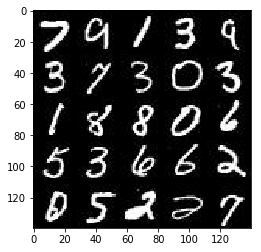

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

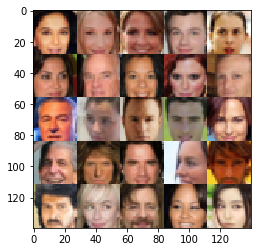

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_images')
    z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32)
    
    return images, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse) as scope:
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x1 = tf.maximum(0.01*x1, x1)
        #14x14x128
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.01*x2, x2)
        #7x7x256    
        
        flat = tf.reshape(x2, (-1, 7*7*256))
        logits = tf.layers.dense(flat,1)
        output = tf.sigmoid(logits)
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.01*x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.01*x2, x2)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3
        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real))
    )    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )

    d_loss = d_loss_real + d_loss_fake    
    return d_loss, g_loss
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Optimizers
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5797... Generator Loss: 1.4633
Epoch 1/2... Discriminator Loss: 0.7191... Generator Loss: 1.1878
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.3861
Epoch 1/2... Discriminator Loss: 0.3153... Generator Loss: 1.9478
Epoch 1/2... Discriminator Loss: 0.4116... Generator Loss: 1.5153
Epoch 1/2... Discriminator Loss: 0.4527... Generator Loss: 2.0017
Epoch 1/2... Discriminator Loss: 0.6451... Generator Loss: 1.1153
Epoch 1/2... Discriminator Loss: 0.6064... Generator Loss: 1.5768
Epoch 1/2... Discriminator Loss: 0.7505... Generator Loss: 0.8583
Epoch 1/2... Discriminator Loss: 0.4751... Generator Loss: 1.7210


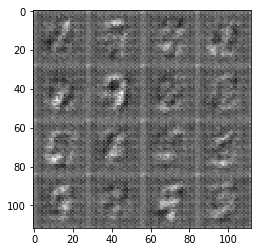

Epoch 1/2... Discriminator Loss: 0.9140... Generator Loss: 0.6231
Epoch 1/2... Discriminator Loss: 0.3542... Generator Loss: 2.0766
Epoch 1/2... Discriminator Loss: 0.4681... Generator Loss: 1.2627
Epoch 1/2... Discriminator Loss: 0.2959... Generator Loss: 2.4822
Epoch 1/2... Discriminator Loss: 0.2922... Generator Loss: 1.9237
Epoch 1/2... Discriminator Loss: 0.3666... Generator Loss: 2.9909
Epoch 1/2... Discriminator Loss: 0.3148... Generator Loss: 1.6821
Epoch 1/2... Discriminator Loss: 0.2130... Generator Loss: 2.4429
Epoch 1/2... Discriminator Loss: 0.3705... Generator Loss: 3.0754
Epoch 1/2... Discriminator Loss: 0.2502... Generator Loss: 1.8846


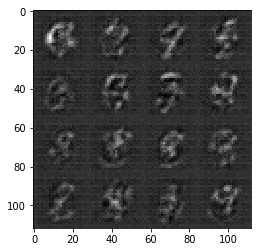

Epoch 1/2... Discriminator Loss: 0.2826... Generator Loss: 1.8191
Epoch 1/2... Discriminator Loss: 0.6239... Generator Loss: 3.7573
Epoch 1/2... Discriminator Loss: 0.2782... Generator Loss: 2.0753
Epoch 1/2... Discriminator Loss: 0.2287... Generator Loss: 2.3075
Epoch 1/2... Discriminator Loss: 0.2602... Generator Loss: 1.8963
Epoch 1/2... Discriminator Loss: 0.7309... Generator Loss: 0.7593
Epoch 1/2... Discriminator Loss: 0.1980... Generator Loss: 2.9314
Epoch 1/2... Discriminator Loss: 0.1693... Generator Loss: 2.6485
Epoch 1/2... Discriminator Loss: 0.2405... Generator Loss: 1.9620
Epoch 1/2... Discriminator Loss: 0.1678... Generator Loss: 2.5181


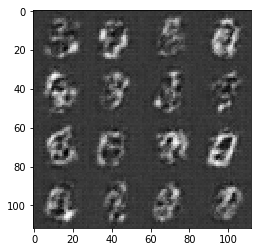

Epoch 1/2... Discriminator Loss: 0.1777... Generator Loss: 2.3387
Epoch 1/2... Discriminator Loss: 0.4184... Generator Loss: 1.4390
Epoch 1/2... Discriminator Loss: 0.3080... Generator Loss: 2.1044
Epoch 1/2... Discriminator Loss: 0.2692... Generator Loss: 1.9034
Epoch 1/2... Discriminator Loss: 0.2207... Generator Loss: 2.5423
Epoch 1/2... Discriminator Loss: 0.2214... Generator Loss: 2.6750
Epoch 1/2... Discriminator Loss: 0.1897... Generator Loss: 2.4701
Epoch 1/2... Discriminator Loss: 0.1931... Generator Loss: 2.5317
Epoch 1/2... Discriminator Loss: 0.1696... Generator Loss: 2.4812
Epoch 1/2... Discriminator Loss: 0.2047... Generator Loss: 2.2914


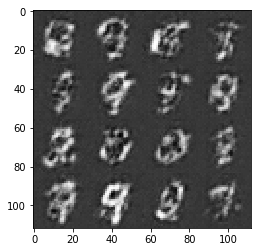

Epoch 1/2... Discriminator Loss: 0.2721... Generator Loss: 2.4277
Epoch 1/2... Discriminator Loss: 0.1928... Generator Loss: 2.4930
Epoch 1/2... Discriminator Loss: 0.1833... Generator Loss: 2.5482
Epoch 1/2... Discriminator Loss: 0.1874... Generator Loss: 2.5000
Epoch 1/2... Discriminator Loss: 0.1889... Generator Loss: 2.4979
Epoch 1/2... Discriminator Loss: 0.1526... Generator Loss: 2.8333
Epoch 2/2... Discriminator Loss: 0.1709... Generator Loss: 2.6077
Epoch 2/2... Discriminator Loss: 0.1675... Generator Loss: 2.8059
Epoch 2/2... Discriminator Loss: 0.1653... Generator Loss: 2.6205
Epoch 2/2... Discriminator Loss: 0.1450... Generator Loss: 3.1007


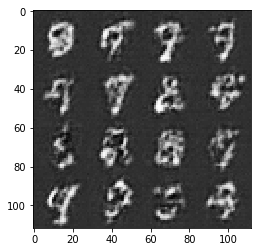

Epoch 2/2... Discriminator Loss: 0.1550... Generator Loss: 2.9786
Epoch 2/2... Discriminator Loss: 0.2084... Generator Loss: 2.2688
Epoch 2/2... Discriminator Loss: 0.1524... Generator Loss: 2.8894
Epoch 2/2... Discriminator Loss: 0.1368... Generator Loss: 3.0574
Epoch 2/2... Discriminator Loss: 0.1507... Generator Loss: 2.5990
Epoch 2/2... Discriminator Loss: 0.1565... Generator Loss: 2.7019
Epoch 2/2... Discriminator Loss: 0.1302... Generator Loss: 3.3181
Epoch 2/2... Discriminator Loss: 0.1409... Generator Loss: 2.9756
Epoch 2/2... Discriminator Loss: 0.1265... Generator Loss: 3.0736
Epoch 2/2... Discriminator Loss: 0.1386... Generator Loss: 2.8848


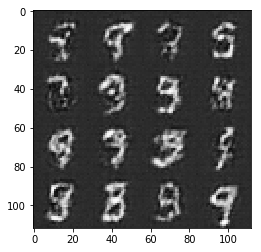

Epoch 2/2... Discriminator Loss: 0.1414... Generator Loss: 2.6458
Epoch 2/2... Discriminator Loss: 1.0512... Generator Loss: 0.6568
Epoch 2/2... Discriminator Loss: 2.9581... Generator Loss: 0.1022
Epoch 2/2... Discriminator Loss: 0.6921... Generator Loss: 1.6737
Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 3.6737
Epoch 2/2... Discriminator Loss: 0.3701... Generator Loss: 2.2043
Epoch 2/2... Discriminator Loss: 0.3636... Generator Loss: 2.5625
Epoch 2/2... Discriminator Loss: 0.3304... Generator Loss: 2.2389
Epoch 2/2... Discriminator Loss: 0.3310... Generator Loss: 2.1126
Epoch 2/2... Discriminator Loss: 0.3216... Generator Loss: 2.2448


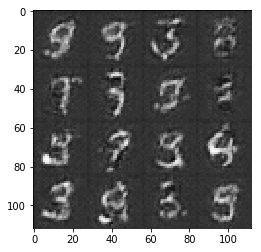

Epoch 2/2... Discriminator Loss: 0.3204... Generator Loss: 1.9959
Epoch 2/2... Discriminator Loss: 0.3168... Generator Loss: 2.0159
Epoch 2/2... Discriminator Loss: 0.2424... Generator Loss: 2.6866
Epoch 2/2... Discriminator Loss: 0.2382... Generator Loss: 2.5649
Epoch 2/2... Discriminator Loss: 0.1806... Generator Loss: 2.5361
Epoch 2/2... Discriminator Loss: 0.1691... Generator Loss: 2.9592
Epoch 2/2... Discriminator Loss: 0.1761... Generator Loss: 2.6064
Epoch 2/2... Discriminator Loss: 0.1642... Generator Loss: 2.6879
Epoch 2/2... Discriminator Loss: 0.1832... Generator Loss: 2.9171
Epoch 2/2... Discriminator Loss: 0.1661... Generator Loss: 2.8991


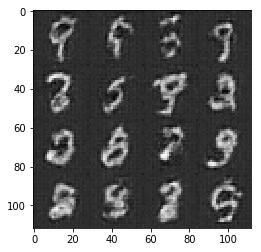

Epoch 2/2... Discriminator Loss: 0.7200... Generator Loss: 0.8652
Epoch 2/2... Discriminator Loss: 0.2510... Generator Loss: 2.2635
Epoch 2/2... Discriminator Loss: 0.2535... Generator Loss: 2.1057
Epoch 2/2... Discriminator Loss: 0.1833... Generator Loss: 2.6104
Epoch 2/2... Discriminator Loss: 0.5317... Generator Loss: 1.1466
Epoch 2/2... Discriminator Loss: 0.2415... Generator Loss: 2.1986
Epoch 2/2... Discriminator Loss: 0.3076... Generator Loss: 1.7994
Epoch 2/2... Discriminator Loss: 0.2244... Generator Loss: 2.2554
Epoch 2/2... Discriminator Loss: 0.1724... Generator Loss: 2.5779
Epoch 2/2... Discriminator Loss: 0.1712... Generator Loss: 3.1479


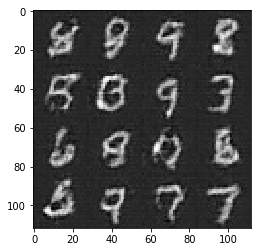

Epoch 2/2... Discriminator Loss: 0.2321... Generator Loss: 2.3607
Epoch 2/2... Discriminator Loss: 0.2569... Generator Loss: 2.1225
Epoch 2/2... Discriminator Loss: 0.1928... Generator Loss: 3.0922


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3172... Generator Loss: 1.8063
Epoch 1/1... Discriminator Loss: 0.2237... Generator Loss: 2.2316
Epoch 1/1... Discriminator Loss: 0.2361... Generator Loss: 2.2207
Epoch 1/1... Discriminator Loss: 0.2515... Generator Loss: 2.4703
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 1.5587
Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 3.9860
Epoch 1/1... Discriminator Loss: 0.3600... Generator Loss: 1.6411
Epoch 1/1... Discriminator Loss: 0.2580... Generator Loss: 2.2377


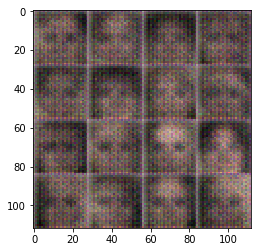

Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 0.2702... Generator Loss: 2.1963
Epoch 1/1... Discriminator Loss: 0.1359... Generator Loss: 3.6190
Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 1.9843
Epoch 1/1... Discriminator Loss: 0.5603... Generator Loss: 4.5378
Epoch 1/1... Discriminator Loss: 0.1969... Generator Loss: 2.2639
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 3.6596
Epoch 1/1... Discriminator Loss: 2.3855... Generator Loss: 0.1349
Epoch 1/1... Discriminator Loss: 0.6142... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 0.2299... Generator Loss: 3.2963


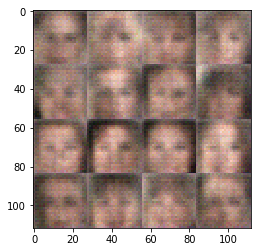

Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 5.1963
Epoch 1/1... Discriminator Loss: 0.1690... Generator Loss: 3.4567
Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 3.8212
Epoch 1/1... Discriminator Loss: 0.1659... Generator Loss: 3.5365
Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 4.3346
Epoch 1/1... Discriminator Loss: 0.1533... Generator Loss: 3.2025
Epoch 1/1... Discriminator Loss: 0.1637... Generator Loss: 2.6659
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 1.9679
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 1.0914
Epoch 1/1... Discriminator Loss: 0.1873... Generator Loss: 3.6532


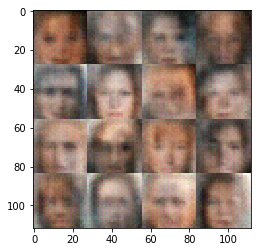

Epoch 1/1... Discriminator Loss: 0.0943... Generator Loss: 4.5368
Epoch 1/1... Discriminator Loss: 0.1425... Generator Loss: 3.9819
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 3.1600
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 1.7505
Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 3.7354
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.4737
Epoch 1/1... Discriminator Loss: 0.1306... Generator Loss: 3.9424
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 0.1485... Generator Loss: 2.9807
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 0.6146


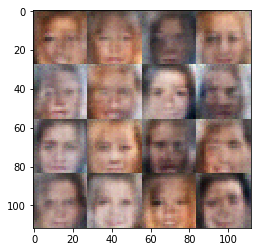

Epoch 1/1... Discriminator Loss: 0.1116... Generator Loss: 3.2838
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 1.5044
Epoch 1/1... Discriminator Loss: 0.2160... Generator Loss: 2.2869
Epoch 1/1... Discriminator Loss: 0.2042... Generator Loss: 4.9104
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.3759
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 0.0623... Generator Loss: 4.7646
Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 12.3655
Epoch 1/1... Discriminator Loss: 0.1195... Generator Loss: 8.3203
Epoch 1/1... Discriminator Loss: 0.8623... Generator Loss: 1.6932


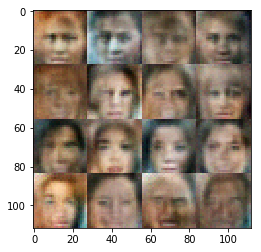

Epoch 1/1... Discriminator Loss: 0.1485... Generator Loss: 7.7663
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 10.2440
Epoch 1/1... Discriminator Loss: 0.2411... Generator Loss: 4.4233
Epoch 1/1... Discriminator Loss: 0.1541... Generator Loss: 6.9262
Epoch 1/1... Discriminator Loss: 0.5836... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.3095
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 7.2077
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 4.6643
Epoch 1/1... Discriminator Loss: 0.1571... Generator Loss: 6.1512
Epoch 1/1... Discriminator Loss: 0.5773... Generator Loss: 1.0106


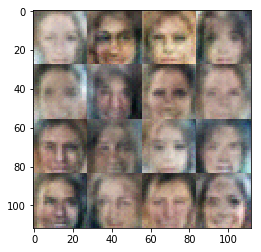

Epoch 1/1... Discriminator Loss: 0.0305... Generator Loss: 7.9757
Epoch 1/1... Discriminator Loss: 0.0634... Generator Loss: 3.9478
Epoch 1/1... Discriminator Loss: 0.1486... Generator Loss: 3.4156
Epoch 1/1... Discriminator Loss: 0.1157... Generator Loss: 7.0020
Epoch 1/1... Discriminator Loss: 1.7596... Generator Loss: 0.2291
Epoch 1/1... Discriminator Loss: 0.0509... Generator Loss: 7.2788
Epoch 1/1... Discriminator Loss: 0.0648... Generator Loss: 12.1233
Epoch 1/1... Discriminator Loss: 0.2294... Generator Loss: 4.2292
Epoch 1/1... Discriminator Loss: 0.0926... Generator Loss: 8.7715
Epoch 1/1... Discriminator Loss: 1.8512... Generator Loss: 0.2204


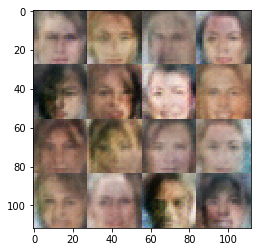

Epoch 1/1... Discriminator Loss: 0.7744... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 0.1380... Generator Loss: 12.8904
Epoch 1/1... Discriminator Loss: 0.1877... Generator Loss: 3.0138
Epoch 1/1... Discriminator Loss: 0.1605... Generator Loss: 9.5340
Epoch 1/1... Discriminator Loss: 0.3794... Generator Loss: 1.5548
Epoch 1/1... Discriminator Loss: 0.1172... Generator Loss: 5.3958
Epoch 1/1... Discriminator Loss: 0.2839... Generator Loss: 8.7360
Epoch 1/1... Discriminator Loss: 0.0446... Generator Loss: 9.6821
Epoch 1/1... Discriminator Loss: 0.1389... Generator Loss: 2.5833
Epoch 1/1... Discriminator Loss: 0.0419... Generator Loss: 5.3875


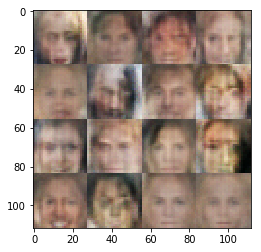

Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 5.3321
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 0.3316... Generator Loss: 1.9010
Epoch 1/1... Discriminator Loss: 0.3057... Generator Loss: 10.4527
Epoch 1/1... Discriminator Loss: 0.5708... Generator Loss: 7.3554
Epoch 1/1... Discriminator Loss: 0.0797... Generator Loss: 5.1049
Epoch 1/1... Discriminator Loss: 0.1455... Generator Loss: 4.7523
Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 1.9221
Epoch 1/1... Discriminator Loss: 0.1048... Generator Loss: 4.5603


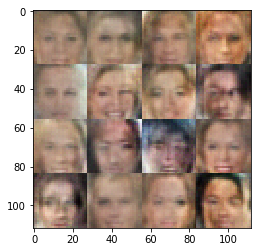

Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 1.3351
Epoch 1/1... Discriminator Loss: 0.1829... Generator Loss: 17.3452
Epoch 1/1... Discriminator Loss: 0.1123... Generator Loss: 3.6068
Epoch 1/1... Discriminator Loss: 0.0684... Generator Loss: 7.9994
Epoch 1/1... Discriminator Loss: 0.0411... Generator Loss: 10.4429
Epoch 1/1... Discriminator Loss: 0.1810... Generator Loss: 2.4769
Epoch 1/1... Discriminator Loss: 0.0676... Generator Loss: 5.4191
Epoch 1/1... Discriminator Loss: 0.5530... Generator Loss: 4.5313
Epoch 1/1... Discriminator Loss: 0.0978... Generator Loss: 9.9058
Epoch 1/1... Discriminator Loss: 0.2606... Generator Loss: 9.0128


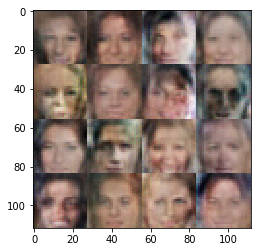

Epoch 1/1... Discriminator Loss: 0.2081... Generator Loss: 3.1071
Epoch 1/1... Discriminator Loss: 0.0677... Generator Loss: 10.2680
Epoch 1/1... Discriminator Loss: 0.0351... Generator Loss: 11.8415
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 0.0624... Generator Loss: 3.9164
Epoch 1/1... Discriminator Loss: 0.0445... Generator Loss: 4.4331
Epoch 1/1... Discriminator Loss: 0.0213... Generator Loss: 7.5425
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 0.0680... Generator Loss: 6.3883
Epoch 1/1... Discriminator Loss: 0.0674... Generator Loss: 5.6151


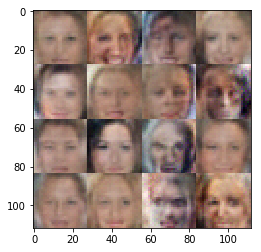

Epoch 1/1... Discriminator Loss: 0.0406... Generator Loss: 7.0797
Epoch 1/1... Discriminator Loss: 0.0916... Generator Loss: 6.5597
Epoch 1/1... Discriminator Loss: 0.0295... Generator Loss: 7.2670
Epoch 1/1... Discriminator Loss: 0.0827... Generator Loss: 3.2950
Epoch 1/1... Discriminator Loss: 0.2824... Generator Loss: 1.9423
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 0.0186... Generator Loss: 14.7498
Epoch 1/1... Discriminator Loss: 0.0550... Generator Loss: 6.0830
Epoch 1/1... Discriminator Loss: 0.0468... Generator Loss: 4.9609
Epoch 1/1... Discriminator Loss: 0.2866... Generator Loss: 1.7983


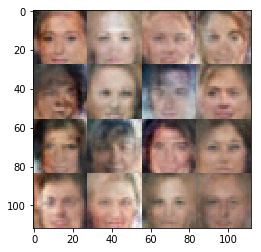

Epoch 1/1... Discriminator Loss: 0.0780... Generator Loss: 6.7759
Epoch 1/1... Discriminator Loss: 0.0397... Generator Loss: 16.2276
Epoch 1/1... Discriminator Loss: 0.1105... Generator Loss: 14.0185
Epoch 1/1... Discriminator Loss: 0.1085... Generator Loss: 3.0094
Epoch 1/1... Discriminator Loss: 0.1473... Generator Loss: 2.6039
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 4.0726
Epoch 1/1... Discriminator Loss: 0.2454... Generator Loss: 3.2462
Epoch 1/1... Discriminator Loss: 0.1461... Generator Loss: 9.0644
Epoch 1/1... Discriminator Loss: 0.0304... Generator Loss: 9.4356
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 0.7899


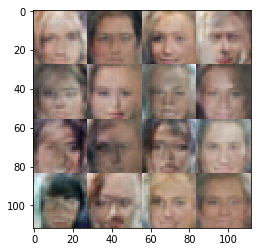

Epoch 1/1... Discriminator Loss: 0.0455... Generator Loss: 4.9790
Epoch 1/1... Discriminator Loss: 0.0315... Generator Loss: 13.0030
Epoch 1/1... Discriminator Loss: 0.0368... Generator Loss: 16.3780
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 10.2588
Epoch 1/1... Discriminator Loss: 0.1252... Generator Loss: 10.4561
Epoch 1/1... Discriminator Loss: 0.2182... Generator Loss: 5.1444
Epoch 1/1... Discriminator Loss: 0.1651... Generator Loss: 3.1462
Epoch 1/1... Discriminator Loss: 0.2279... Generator Loss: 12.2621
Epoch 1/1... Discriminator Loss: 0.0458... Generator Loss: 14.4074
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 2.3834


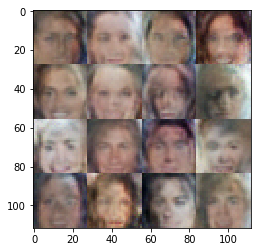

Epoch 1/1... Discriminator Loss: 0.0893... Generator Loss: 7.4272
Epoch 1/1... Discriminator Loss: 0.0444... Generator Loss: 5.0439
Epoch 1/1... Discriminator Loss: 0.0791... Generator Loss: 14.2228
Epoch 1/1... Discriminator Loss: 0.0365... Generator Loss: 10.2394
Epoch 1/1... Discriminator Loss: 0.1715... Generator Loss: 2.8275
Epoch 1/1... Discriminator Loss: 0.0602... Generator Loss: 5.1877
Epoch 1/1... Discriminator Loss: 0.3426... Generator Loss: 1.6460
Epoch 1/1... Discriminator Loss: 0.0611... Generator Loss: 3.8741
Epoch 1/1... Discriminator Loss: 0.1489... Generator Loss: 3.4443
Epoch 1/1... Discriminator Loss: 0.0304... Generator Loss: 9.3894


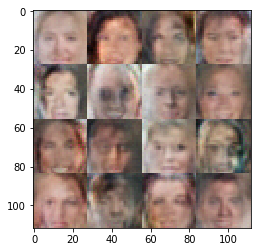

Epoch 1/1... Discriminator Loss: 0.0504... Generator Loss: 12.9978
Epoch 1/1... Discriminator Loss: 0.3317... Generator Loss: 2.9529
Epoch 1/1... Discriminator Loss: 0.0765... Generator Loss: 4.8215
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 9.4997
Epoch 1/1... Discriminator Loss: 0.0590... Generator Loss: 10.7267
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 1.2303
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 15.3857
Epoch 1/1... Discriminator Loss: 0.0757... Generator Loss: 3.4580


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.